In [1]:
from servier.data import get_data, LOCAL_PATH

In [2]:
df = get_data()

# Sandbox

In [3]:
from keras.layers.embeddings import Embedding
from keras.layers.experimental.preprocessing import TextVectorization

embedding_vector_length, max_length, vocab_size = 32, 74, 27

vectorize_layer = TextVectorization(
   max_tokens=vocab_size,
   output_mode='int',
   output_sequence_length=max_length
)
model = Sequential()
model.add(vectorize_layer)

#model.add(Embedding(input_dim=vocab_size,output_dim=embedding_vector_length,input_length=max_length))

NameError: name 'Sequential' is not defined

In [ ]:
aa = model.predict(X.smiles.values)

In [ ]:
aa[0]

In [4]:
len(sigles)

NameError: name 'sigles' is not defined

# Pipeline

In [5]:
from sklearn.utils import resample
import pandas as pd

def resample_data(df, up=False, target='P1'):
    # Separate majority and minority classes
    majority_class = df[target].mode().values[0]
    df_majority = df[df[target] == majority_class]
    df_minority = df[df[target] == 1-majority_class]

    n_minority = df_minority.shape[0]
    n_majority = df_majority.shape[0]
    seed = 123

    if up:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,  # sample with replacement
                                         n_samples=n_majority,  # to match majority class
                                         random_state=seed)  # reproducible results

        # Combine majority class with upsampled minority class
        df_new = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False,  # sample without replacement
                                           n_samples=n_minority,  # to match minority class
                                           random_state=seed)  # reproducible results
        # Combine minority class with downsampled majority class
        df_new = pd.concat([df_majority_downsampled, df_minority])
    return df_new

In [8]:
def textvectorizer(X):
    vocab = list({l for word in X.smiles.values for l in word})
    vocab_size = len(vocab)
    max_len = X.smiles.map(len).max()
    vect_cols = ['v_' + str(k) for k in range(max_len)]
    d = {k: v for k, v in zip(vocab, range(1, max_len))}
    d['0'] = 0
    X['zfill_smiles'] = X.smiles.str.pad(width=max_len, side='right', fillchar='0')
    X[vect_cols] = X.zfill_smiles.apply(lambda x: pd.Series(list(x)))
    X[vect_cols] = X[vect_cols].replace(d)
    return X

In [9]:

from keras.layers import BatchNormalization
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, Flatten
from keras.layers.merge import concatenate
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.experimental.preprocessing import TextVectorization

embedding_vector_length, max_length, vocab_size = 32, 72, 29+1

def get_model(size, verbose=False):
    model = Sequential([
        Dense(size, input_shape=(size,), activation="relu"),
        Dense(256, activation="sigmoid"),
        Dense(64, activation="sigmoid"),
        Dense(34, activation="sigmoid"),
        Dense(16, activation="sigmoid"),
        BatchNormalization(axis=1),
        Dense(2, activation="sigmoid")
    ])
    if verbose:
        model.summary()
    model.compile(optimizer=Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def GRU2_model(X,Y, dropout=0, epochs=10, batch_size=32):
    """
    Module that creates a 2 layer GRU for property prediction from SMILES
    """

    vectorize_layer = TextVectorization(
       max_tokens=vocab_size,
       output_mode='int',
       output_sequence_length=max_length
    )
    model = Sequential()
    model.add(vectorize_layer)
    model.add(Embedding(input_dim=vocab_size,output_dim=embedding_vector_length,input_length=max_length))

    model.add(GRU(100, return_sequences=True, dropout=dropout))
    model.add(GRU(100, dropout=dropout))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    #model.summary()
    history = model.fit(X, Y, validation_split=0.1, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    #save_model("gru_2layer", model, history, dropout, epochs, batch_size)
    return model

def GRU_model(X,Y, dropout=0, epochs=2, batch_size=2):

    """
    Module that creates a 1 layer GRU for property prediction from SMILES
    """
    
    vectorize_layer = TextVectorization(
       max_tokens=vocab_size,
       output_mode='int',
       output_sequence_length=max_length
    )
    model = Sequential()
    model.add(vectorize_layer)
    model.add(Embedding(input_dim=vocab_size,output_dim=embedding_vector_length,input_length=max_length))

    model.add(GRU(100, dropout=dropout))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #model.summary()
    history = model.fit(X, Y, validation_split=0.1, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    #save_model("gru_1layer", model, history, dropout, epochs, batch_size)
    return model

def cnn_model(optimizer="adam", lr=0.001, dropout=0, layers=2):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=embedding_vector_length,input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    if layers==3:
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    if optimizer == "adam" and lr!= 0.001:
        print("Setting learning rate to"+str(lr))
        optimizer = tf.train.AdamOptimizer(lr)

    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    #history = model.fit(X, Y, validation_split=0.1, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    return model

def rnn_model(optimizer="adam",lr=0.001, dropout=0, gate="lstm", gated_layers= 2, num_gated_connections=100,vocab=vocab_size,embedding_length=embedding_vector_length, max_len=max_length):
    model = Sequential()
    model.add(Embedding(vocab, embedding_length, input_length=max_len))

    if gated_layers==2:
        if gate == "lstm":
            model.add(LSTM(num_gated_connections, return_sequences=True, dropout=dropout))
        else:#gate=gru
            model.add(GRU(num_gated_connections, return_sequences=True, dropout=dropout))

    if gate == "lstm":
        model.add(LSTM(num_gated_connections, dropout=dropout))
    else:#gate=="gru"
        model.add(GRU(num_gated_connections, dropout=dropout))

    model.add(Dense(1,activation="sigmoid"))

    if optimizer == "adam" and lr!= 0.001:
        print("Setting learning rate to"+str(lr))
        optimizer = tf.train.AdamOptimizer(lr)

    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    #model.summary()
    return model

def bidirectional_rnn_model(optimizer="adam", lr=0.001, dropout=0, gate = "lstm", gated_layers= 1, num_gated_connections=100,vocab=vocab_size,embedding_length=embedding_vector_length,\
              max_len=max_length):
    model = Sequential()
    model.add(Embedding(vocab, embedding_length, input_length=max_len))
    if gated_layers==2:
        if gate == "lstm":
            model.add(Bidirectional(LSTM(num_gated_connections, return_sequences=True, dropout=dropout)))
        else:#gate=gru
            model.add(Bidirectional(GRU(num_gated_connections, return_sequences=True, dropout=dropout)))

    if gate == "lstm":
        model.add(Bidirectional(LSTM(num_gated_connections, dropout=dropout)))
    else:#gate=gru
        model.add(Bidirectional(GRU(num_gated_connections, dropout=dropout)))
    
    model.add(Dense(1,activation="sigmoid"))

    if optimizer == "adam" and lr!= 0.001:
        print("Setting learning rate to"+str(lr))
        optimizer = tf.train.AdamOptimizer(lr)

    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    #model.summary()
    return model

def cnn_mlp_model(X1, X2, y, epochs=2, batch_size=2, optimizer="adam", lr=0.001, dropout= 0.0, layers=2, fp="maccs",vocab=vocab_size,embedding_length=embedding_vector_length,max_len=max_length):
    """
    Replaces the merged cnn_lstm_mlp and cnn_gru_mlp
    """
    #vectorize_layer = TextVectorization(
    #   max_tokens=vocab,
    #   output_mode='int',
    #   output_sequence_length=max_len, input_shape=(None, 1)
    #)
    cnn_model = Sequential()
    #cnn_model.add(vectorize_layer)
    cnn_model.add(Embedding(vocab, embedding_length, input_length=max_len))
    cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    if layers==3:
        cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64))

    fc_model = Sequential()
    fc_model.add(Dense(256, activation="relu"))
    fc_model.add(Dropout(dropout))
    fc_model.add(Dense(64, activation="relu"))

    
    model_concat = concatenate([cnn_model.output, fc_model.output], axis=-1)
    model_concat = Dense(64)(model_concat)
    model = Model(inputs=[model1.input, model2.input], outputs=model_concat)    

    
    #concatenated = concatenate([cnn_model, fc_model])
    #model = Dense(64)(concatenated)
    #model = Sequential()
    #model.add(Merge([cnn_model, fc_model], mode='concat'))
    #model.add(Dense(64))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation="sigmoid"))

    if optimizer == "adam" and lr!= 0.001:
        print("Setting learning rate to"+str(lr))
        optimizer = tf.train.AdamOptimizer(lr)

    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    model.fit([X1, X2], y, validation_split=0.1, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    return model

In [10]:
from servier.data import get_data, get_X_y
from servier.feature_extractor import df_to_features
df = get_data()
#df = resample_data(df, up=True, target='P1')

In [11]:
df_fp = df_to_features(df)
df_fp = textvectorizer(df_fp)

In [12]:
X_vect = df_fp.filter(regex='v_').values
X_morgan_fp = df_fp.filter(regex='Bit').values
y = df.P1.values

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
X_train, y_train = X_vect, y
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.10)

In [14]:
#morgan_fp_encoder = make_pipeline(MorganFingerprintEncoder(size=self.fp_size))
epochs=10
batch_size=10

cnn = cnn_model()
rnn = rnn_model()
bidir_rnn = bidirectional_rnn_model()
#model = cnn_model(X_vect, y)

In [15]:
cnn.fit(X_vect, y, batch_size=batch_size, epochs=epochs)

Epoch 1/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4674 - acc: 0.8200
Epoch 2/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4313 - acc: 0.8222
Epoch 3/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4179 - acc: 0.8226
Epoch 4/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4133 - acc: 0.8253
Epoch 5/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4059 - acc: 0.8233
Epoch 6/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4046 - acc: 0.8289
Epoch 7/10
450/450 [==============================] - 1s 3ms/step - loss: 0.3947 - acc: 0.8273
Epoch 8/10
450/450 [==============================] - 1s 3ms/step - loss: 0.3858 - acc: 0.8306
Epoch 9/10
450/450 [==============================] - 1s 3ms/step - loss: 0.3773 - acc: 0.8344
Epoch 10/10
450/450 [==============================] - 1s 3ms/step - loss: 0.3627 - acc: 0.8404


In [71]:
bidir_rnn.fit(X_vect, y, batch_size=batch_size, epochs=epochs)

Epoch 1/10
740/740 [==============================] - 23s 31ms/step - loss: 0.6642 - acc: 0.6012
Epoch 2/10
740/740 [==============================] - 24s 32ms/step - loss: 0.6215 - acc: 0.6593
Epoch 3/10
740/740 [==============================] - 24s 33ms/step - loss: 0.6075 - acc: 0.6696
Epoch 4/10
740/740 [==============================] - 24s 33ms/step - loss: 0.6006 - acc: 0.6692
Epoch 5/10
740/740 [==============================] - 25s 33ms/step - loss: 0.5944 - acc: 0.6715
Epoch 6/10
740/740 [==============================] - 24s 33ms/step - loss: 0.5917 - acc: 0.6708
Epoch 7/10
740/740 [==============================] - 25s 33ms/step - loss: 0.5856 - acc: 0.6826
Epoch 8/10
740/740 [==============================] - 25s 33ms/step - loss: 0.5836 - acc: 0.6808
Epoch 9/10
740/740 [==============================] - 25s 34ms/step - loss: 0.5791 - acc: 0.6856
Epoch 10/10
740/740 [==============================] - 25s 34ms/step - loss: 0.5733 - acc: 0.6948


In [16]:
import copy
import matplotlib.pyplot as plt
from servier.utils import perf_eval_classif

def plot_confusion_wiki(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    confmat_wiki = copy.copy(confmat.T)
    confmat_wiki[0][0] = confmat[1][1]
    confmat_wiki[1][1] = confmat[0][0]
    ax.matshow(confmat_wiki, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat_wiki.shape[0]):
        for j in range(confmat_wiki.shape[1]):
            ax.text(x=j, y=i, s=confmat_wiki[i, j], va='center', ha='center')
    ax.set_xticklabels([0, 1])
    ax.set_yticklabels([0, 1])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.tight_layout()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
450/450 [==============================] - 0s 491us/step
{'ROC': 0.6217905405405405,
 'confusion_matrix': array([[ 21,  59],
       [  7, 363]]),
 'f1': 0.9166666666666667,
 'precision': 0.8601895734597157,
 'recall': 0.981081081081081}


/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


450/450 [==============================] - 2s 5ms/step
{'ROC': 0.5,
 'confusion_matrix': array([[  0,  80],
       [  0, 370]]),
 'f1': 0.9024390243902439,
 'precision': 0.8222222222222222,
 'recall': 1.0}


/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


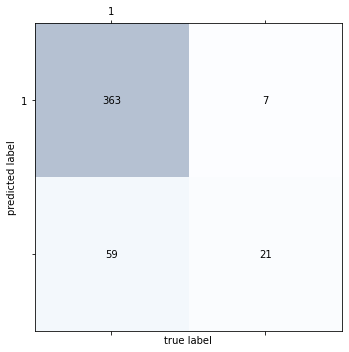

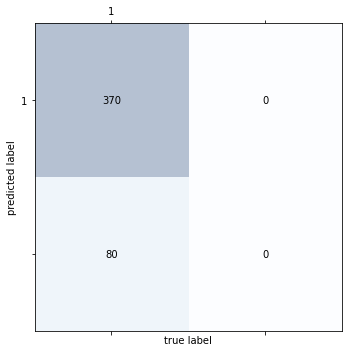

In [17]:
from pprint import pprint
for model in [cnn, bidir_rnn]:
    y_pred = model.predict_classes(X_test, batch_size=1, verbose=1)
    perf_eval = perf_eval_classif(y_test, y_pred, verbose=False)
    pprint(perf_eval)
    plot_confusion_wiki(perf_eval['confusion_matrix'])

450/450 [==============================] - 0s 540us/step
{'ROC': 0.5324324324324324,
 'confusion_matrix': array([[  8,  72],
       [ 13, 357]]),
 'f1': 0.8936170212765957,
 'precision': 0.8321678321678322,
 'recall': 0.9648648648648649}
 19/450 [>.............................] - ETA: 2s

/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


450/450 [==============================] - 2s 5ms/step
{'ROC': 0.5,
 'confusion_matrix': array([[  0,  80],
       [  0, 370]]),
 'f1': 0.9024390243902439,
 'precision': 0.8222222222222222,
 'recall': 1.0}


/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


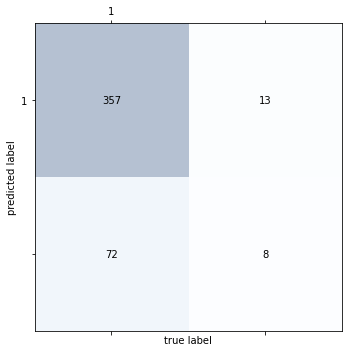

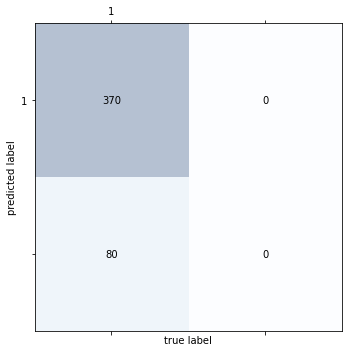

In [244]:
from pprint import pprint
for model in [cnn, bidir_rnn]:
    y_pred = model.predict_classes(X_test, batch_size=1, verbose=1)
    perf_eval = perf_eval_classif(y_test, y_pred, verbose=False)
    pprint(perf_eval)
    plot_confusion_wiki(perf_eval['confusion_matrix'])

In [213]:
y_pred

array([[0.86631954],
       [0.36251348],
       [0.89754677],
       [0.99899244],
       [0.63933504],
       [0.59948456],
       [0.8991308 ],
       [0.7721048 ],
       [0.33270013],
       [0.5773576 ],
       [0.94462574],
       [0.970965  ],
       [0.8724753 ],
       [0.82433987],
       [0.53394896],
       [0.9716338 ],
       [0.90846133],
       [0.9890896 ],
       [0.89987373],
       [0.9558434 ],
       [0.8888262 ],
       [0.93293107],
       [0.9963488 ],
       [0.6827782 ],
       [0.75925565],
       [0.9207219 ],
       [0.9998479 ],
       [0.6847439 ],
       [0.8975028 ],
       [0.82905877],
       [0.9000029 ],
       [0.89533246],
       [0.67384255],
       [0.8736645 ],
       [0.9614015 ],
       [0.64416194],
       [0.8379444 ],
       [0.74926853],
       [0.9355785 ],
       [0.77465606],
       [0.9780941 ],
       [0.6326756 ],
       [0.84552294],
       [0.7432962 ],
       [0.7909516 ],
       [0.92200065],
       [0.9290662 ],
       [0.992

In [265]:
df = get_data()
df2 = resample_data(df, up=True, target='P1')

In [273]:
from servier.utils import describe_df
describe_df(df)

,type,nan,unique,values,hist
Unnamed: 0,int64,0,4499,"[231, 4043, 990, 4750, 2402, 4016, 4371, 406, ...","{""2047"":0,""4651"":0,""2592"":0,""2596"":0,""549"":0,""..."
P1,int64,0,2,"[1, 0]","{""1"":82,""0"":17}"
mol_id,object,0,4499,"[CID3245855, CID1284913, CID895682, CID661792,...","{""CID5307395"":0,""CID3242837"":0,""CID2985216"":0,..."
smiles,object,0,4499,"[CCC1CCCCN1CCCNC(=O)CNC(=O)Cn1ccc2ccccc2c1=O, ...","{""N\/C(=N\\N=C\\c1ccc2c(c1)OCO2)SC1CC(=O)N(c2c..."


In [267]:
describe_df(df2)

,type,nan,unique,values,hist
Unnamed: 0,int64,0,4494,"[3930, 2072, 270, 4606, 3052, 4751, 4045, 3361...","{""4436"":0,""3825"":0,""4178"":0,""3006"":0,""3940"":0,..."
P1,int64,0,2,"[1, 0]","{""1"":50,""0"":50}"
mol_id,object,0,4494,"[CID5072899, CID20557, CID3163217, CID3242100,...","{""CID658474"":0,""CID659667"":0,""CID665691"":0,""CI..."
smiles,object,0,4494,"[CCCCn1c(CCCNC(=O)CC)nc2ccccc21, O=C1C2(c3cccc...","{""Cc1nc(-c2cn[nH]c2)c2cc(C)oc2n1"":0,""CCCc1nnc(..."


In [2]:
df = get_data()

NameError: name 'get_data' is not defined

In [1]:
from servier.data import split_train_test

In [274]:
df

,Unnamed: 0,P1,mol_id,smiles
0,231,1,CID3245855,CCC1CCCCN1CCCNC(=O)CNC(=O)Cn1ccc2ccccc2c1=O
1,4043,1,CID1284913,O=C(c1ccccc1NS(=O)(=O)c1ccc(Br)s1)N1CCOCC1
2,990,1,CID895682,CCN1CCN(C(=S)Nc2cccc(Cl)c2)CC1
3,4750,1,CID661792,COc1ccc(N2C(=O)CC(NCc3cccs3)C2=O)cc1
4,2402,1,CID661508,O=C(NC1CCCCC1)n1c(=O)oc2cc(S(=O)(=O)N3CCCCC3)c...
...,...,...,...,...
4494,3371,0,CID663175,CCOC(=O)c1ccc(N2C(=O)c3n[nH]c(C)c3C2c2ccco2)cc1
4495,649,1,CID3603126,COc1ccc(N2CCN(C(c3ccccc3)c3sc4nc(C)nn4c3O)CC2)cc1
4496,3607,1,CID1308633,O=C(COc1ccc(Br)cc1)Nc1ccccc1N1CCCC1
4497,1999,1,CID4072173,O=C(NCC1CCCO1)c1ccc2c(=O)n(CC3CCCO3)c(=S)[nH]c2c1
